(FeedForwardNeuralNetworks)=
# Feed-forward neural network

As neural networks are a pillar in both the early and the recent advances of artificial intelligence, their use for credit card fraud detection is not surprising. The first examples of simple feed-forward neural networks applied to fraud detection can bring us back to the early 90s {cite}`ghosh1994credit,aleskerov1997cardwatch`. Naturally, in recent FDS studies, neural networks are often found in experimental benchmarks, along with random forests, XGBoost, or logistic regression. 

At the core of a feed-forward neural network is the artificial neuron, a simple machine learning model that consists of a linear combination of input variables followed by the application of an activation function $\sigma$ (sigmoid, ReLU, tanh, ...). More precisely, given a list of $n$ input variables $x_i$, the output $h$ of the artificial neuron is computed as follows:

$h = \sigma(\sum_{i=1}^n w_i*x_i)$

where $w_i$ are the weights of the model.

A whole network is composed of a succession of layers containing neurons that take, as inputs, the output values of the previous layer.

![A feed forward neural network architecture](./images/neuralnetwork.png)

When applied to the fraud detection problem, the architecture is designed as follows:

* At the beginning of the network, the neurons take as input the characteristics of a credit card transaction, i.e. the features that were defined in the previous chapters.
* At the end, the network outputs a single neuron that aims at representing the probability for the input transaction to be a fraud. 

The rest of the architecture (other layers), the neurons specificity (activation functions), and other hyperparameters (optimization, data processing, ...) are left to the practitioner's choice. 

The most popular training algorithm for feedforward architectures is backpropagation {cite}`hecht1992theory`. The idea is to iterate over all samples of the dataset and perform two key operations: 
* the forward pass: setting the sample's features values in the input neurons and computing all the layers to finally obtain a predicted output.
* the backward pass: computing a cost function, i.e. a discrepancy between the prediction and the expected ground truth output, and trying to minimize it with an optimizer (e.g. gradient descent) by updating weights layer after layer, from output to input. 

This section covers the design of a feed-foward neural network for fraud detection. It describes how to:
* Implement a first simple neural network and study the impact of several architectures and design choices.
* Wrap it to make it compatible with the model selection methodology from Chapter 5 and run a grid-search to select its optimal parameters.
* Store the important functions for a final comparison between deep learning techniques and other baselines at the end of the chapter.

Let us first start by importing all the necessary libraries and functions and retrieving the simulated data. 

In [2]:
import os

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed

Cloning into 'simulated-data-transformed'...
remote: Enumerating objects: 189, done.
remote: Total 189 (delta 0), reused 0 (delta 0), pack-reused 189 (from 1)
Receiving objects: 100% (189/189), 75.79 MiB | 46.61 MiB/s, done.


In [3]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
# !curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py


## Data Loading

The experimental setup is the same as in Chapter 5. More precisely, at the end of the chapter, model selection will be based on a grid search with multiple validations. Each time, one week of data will be used for training a neural network and one week of data for testing the predictions.

To implement the first base network and explore several architecture choices, let us start by selecting a training and validation period arbitrarily. The experiments will be based on the transformed simulated data (`simulated-data-transformed/data/`) and the same feature set as other models.

In [4]:
DIR_INPUT='simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: user 177 ms, sys: 182 ms, total: 360 ms
Wall time: 359 ms
919767 transactions loaded, containing 8195 fraudulent transactions


In [5]:
# Setting the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)
# By default, scaling the input data
(train_df, test_df)=scaleData(train_df,test_df,input_features)

## Overview of the neural network pipeline

The first step here is to implement a base neural network. There are several Python libraries that we can use (TensorFlow, PyTorch, Keras, MXNet, ...). In this book, the PyTorch library {cite}`paszke2017automatic` is used, but the models and benchmarks that will be developed could also be implemented with other libraries.

In [6]:
import torch

If torch and cuda libraries are installed properly, the models developed in this chapter can be trained on the GPU. For that, let us create a "DEVICE" variable and set it to "cuda" if a cuda device is available and "cpu" otherwise. In the rest of the chapter, all the models and tensors will be sent to this device for computations.

In [7]:
if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cpu


To ensure reproducibility, a random seed will be fixed like in previous chapters. Additionally to setting the seed for `NumPy` and `random`, it is necessary to set it for `torch`:

In [8]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

The function `seed_everything` defined above will be run before each model initialization and training.

Before diving into the neural network implementation, let us summarize the main elements of a deep learning training/testing pipeline in Torch:
* Datasets/Dataloaders: It is recommended to manipulate data with specific PyTorch classes. [Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) is the interface to access the data. Given a sample's index, it provides a well-formed input-output for the model. [Dataloader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) takes the Dataset as input and provides an iterator for the training loop. It also allows to create batches, shuffle data, and parallelize data preparation. 
* Model/Module: Any model in PyTorch is a [torch.module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). It has an init function in which it instantiates all the necessary submodules (layers) and initializes their weights. It also has a forward function that defines all the operations of the forward pass. 
* The optimizer: The [optimizer](https://pytorch.org/docs/stable/optim.html) is the object that implements the optimization algorithm. It is called after the loss is computed to calculate the necessary model updates. The most basic one is SGD, but there are many others like RMSProp, Adagrad, Adam, ...
* Training loop and evaluation: the training loop is the core of a model's training. It consists in performing several iterations (epochs), getting all the training batches from the loader, performing the forward pass, computing the loss, and calling the optimizer. After each epoch, an evaluation can be performed to track the model's evolution and possibly stop the process.

The next subsections describe and implement in details each of these elements.

### Data management: Datasets and Dataloaders

The first step is to convert our data into objects that PyTorch can use, like `FloatTensors`.

In [9]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_test = torch.FloatTensor(test_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_test = torch.FloatTensor(test_df[output_feature].values)

Next comes the definition of a custom `Dataset`. This dataset is initialized with `x_train`/`x_test` and `y_train`/`y_test` and returns the individual samples in the format required by our model, after sending them to the right device. 

In [10]:
class FraudDataset(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        'Initialization'
        self.x = x
        self.y = y

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        if self.y is not None:
            return self.x[index].to(DEVICE), self.y[index].to(DEVICE)
        else:
            return self.x[index].to(DEVICE)

Note: This first custom Dataset `FraudDataset` seems useless because its role is very limited (simply returning a row from x and y) and because the matrices x and y are already loaded in RAM. This example is provided for educational purposes. But the concept of Dataset has a high interest when sample preparation requires more preprocessing. For instance, it becomes very handy for sequence preparation when using recurrent models (like an LSTM). This will be covered more in-depth later in this chapter but for example, a Dataset for sequential models performs several operations before returning a sample: searching for the history of transactions of the same cardholder and appending it to the current transaction before returning the whole sequence. It avoids preparing all the sequences in advance, which would entail repeating several transactions' features in memory and consuming more RAM than necessary. Datasets objects are also useful when dealing with large image datasets in order to load the images on the fly.

Now that `FraudDataset` is defined, one can choose the training/evaluation parameters and instantiate DataLoaders. For now, let us consider a batch size of 64: this means that at each optimization step, 64 samples will be requested to the Dataset, turned into a batch, and go through the forward pass in parallel. Then the aggregation (sum or average) of the gradient of their losses will be used for backpropagation. 

For the training DataLoader, the shuffle option will be set to `True` so that the order of the data seen by the model will not be the same from one epoch to another. This is recommended and known to be beneficial in Neural Network training {cite}`ruder2016overview`.

In [11]:
train_loader_params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 0}
test_loader_params = {'batch_size': 64,
          'num_workers': 0}

# Generators

training_set = FraudDataset(x_train, y_train)

testing_set = FraudDataset(x_test, y_test)


training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
testing_generator = torch.utils.data.DataLoader(testing_set, **test_loader_params)

The `num_workers` parameter allows parallelizing batch preparation. It can be useful when the `Dataset` requires a lot of processing before returning a sample. Here we do not use multiprocessing so we set `num_workers` to 0.

### The model aka the module

After defining the data pipeline, the next step is to design the module. Let us start with a first rather simple feed-forward neural network. 

As suggested in the introduction, the idea is to define several fully connected layers (`torch.nn.Linear`). A first layer `fc1` which takes as input as many neurons as there are features in the input x. It can be followed by a hidden layer with a chosen number of neurons (`hidden_size`). Finally comes the output layer which has a single output neuron to fit the label (`fraud` or `genuine`, represented by 1 and 0). 

In the past, the sigmoid activation function used to be the primary choice for all activation functions in all layers of a neural network. Today, the preferred choice is `ReLU` (or variants like `eLU`, `leaky ReLU`), at least for the intermediate neurons. It has empirically proven to be a better choice for optimization and speed {cite}`nair2010rectified`. For output neurons, the choice depends on the range or the expected distribution for the output value to be predicted.

Below are plotted the output of several activation functions with respect to their input value to show how they behave and how they are distributed:

In [12]:
%%capture

fig_activation, axs = plt.subplots(3, 2,figsize=(11, 13))

input_values = torch.arange(-5, 5, 0.05)

#linear activation
output_values = input_values
axs[0, 0].plot(input_values, output_values)
axs[0, 0].set_title('Linear')
axs[0, 0].set_ylim([-5.1,5.1])

#heavyside activation
output_values = input_values>0
axs[0, 1].plot(input_values, output_values)
axs[0, 1].set_title('Heavyside (perceptron)')
axs[0, 1].set_ylim([-0.1,1.1])

#sigmoid activation
activation = torch.nn.Sigmoid()
output_values = activation(input_values)
axs[1, 0].plot(input_values, output_values)
axs[1, 0].set_title('Sigmoid')
axs[1, 0].set_ylim([-1.1,1.1])

#tanh activation
activation = torch.nn.Tanh()
output_values = activation(input_values)
axs[1, 1].plot(input_values, output_values)
axs[1, 1].set_title('Tanh')
axs[1, 1].set_ylim([-1.1,1.1])

#relu activation
activation = torch.nn.ReLU()
output_values = activation(input_values)
axs[2, 0].plot(input_values, output_values)
axs[2, 0].set_title('ReLU')
axs[2, 0].set_ylim([-0.5,5.1])

#leaky relu activation
activation = torch.nn.LeakyReLU(negative_slope=0.05)
output_values = activation(input_values)
axs[2, 1].plot(input_values, output_values)
axs[2, 1].set_title('Leaky ReLU')
axs[2, 1].set_ylim([-0.5,5.1])

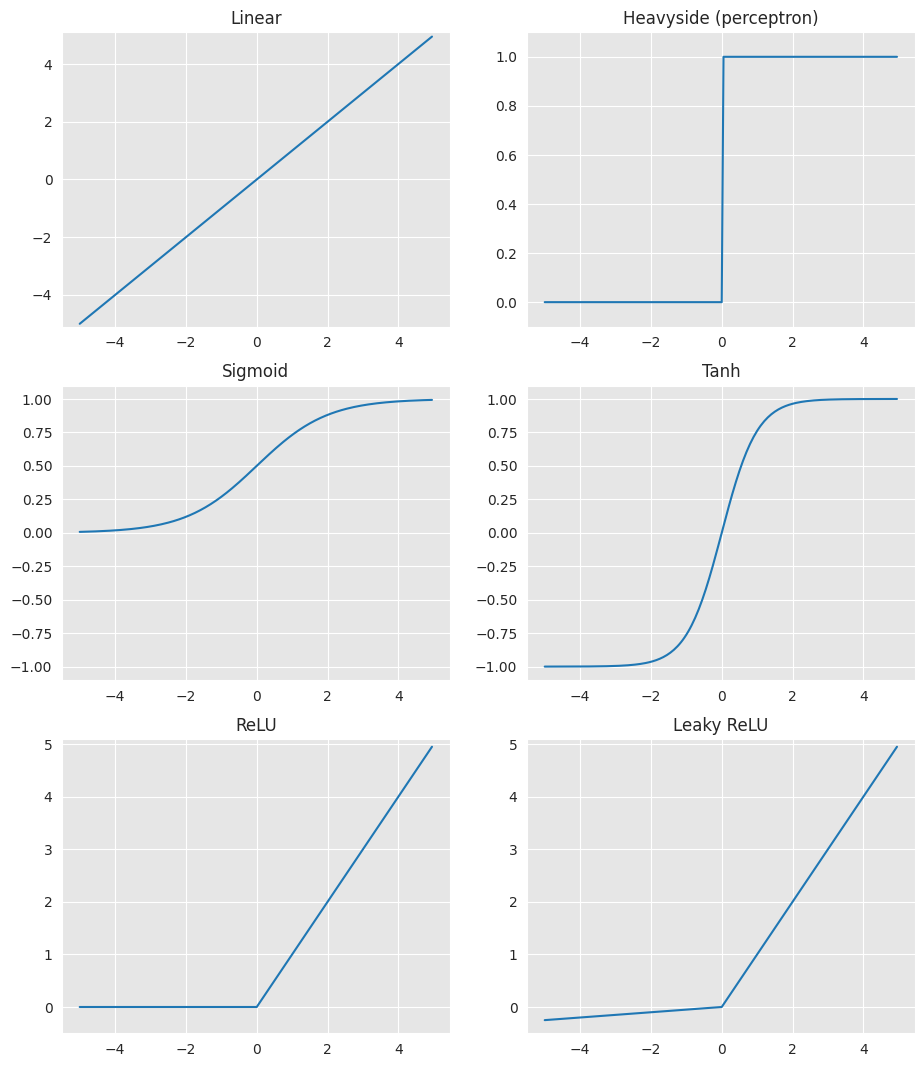

In [13]:
fig_activation

For our fraud detection neural network, the `ReLU` activation will be used for the hidden layer and a `Sigmoid` activation for the output layer. The first is the primary choice for intermediate layers in deep learning. The latter is the primary choice for the output neurons in binary classification problems because it outputs values between 0 and 1 that can be interpreted as probabilities.

To implement this, let us create a new class `SimpleFraudMLP` that will inherit from a torch module. Its layers (`fc1`, `relu`, `fc2`, `sigmoid`) are initialized in the `__init__` function and will be used successively in the forward pass.  

In [14]:
class SimpleFraudMLP(torch.nn.Module):
    
        def __init__(self, input_size, hidden_size):
            super(SimpleFraudMLP, self).__init__()
            # parameters
            self.input_size = input_size
            self.hidden_size  = hidden_size
            
            #input to hidden
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            
            return output

Once defined, instantiating the model with `1000` neurons in its hidden layer and sending it to the device can be done as follows:

In [15]:
model = SimpleFraudMLP(len(input_features), 1000).to(DEVICE)

### The optimizer and the training loop

Optimization is at the core of neural network training. The above neural network is designed to output a single value between 0 and 1. The goal is that this value gets as close to 1 (resp. 0) as possible for an input describing a fraudulent (resp. genuine) transaction.

In practice, this goal is formulated with an optimization problem that aims at minimizing or maximizing some cost/loss function. The role of the loss function is precisely to measure the discrepancy between the predicted value and the expected value (0 or 1), also referred to as the ground truth. There are many loss functions (mean squared error, cross-entropy, KL-divergence, hinge loss, mean absolute error) available in PyTorch, and each serves a specific purpose. Here we only focus on binary cross-entropy because it is the most relevant loss function for binary classification problems like fraud detection. It is defined as follows:

$BCE(y,p) = −(y*log(p)+(1−y)*log(1−p))$

Where $y$ is the ground truth (in $\{0,1\}$) and $p$ the predicted output (in $]0,1[$).

In [16]:
criterion = torch.nn.BCELoss().to(DEVICE)

Note: Pushing the criterion to the device is only required if this one stores/updates internal state variables or has parameters. It is unnecessary but not detrimental in the above case. We do it to show the most general implementation.

Before even training the model, one can already measure its initial loss on the testing set. For this, the model has to be put in `eval` mode:

In [17]:
model.eval()

SimpleFraudMLP(
  (fc1): Linear(in_features=15, out_features=1000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Then, the process consists in iterating over the testing generator, making predictions, and evaluating the chosen `criterion` (here `torch.nn.BCELoss`)

In [18]:
def evaluate_model(model,generator,criterion):
    model.eval()
    batch_losses = []
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        batch_losses.append(loss.item())
    mean_loss = np.mean(batch_losses)    
    return mean_loss
    
evaluate_model(model,testing_generator,criterion)

0.6754083175428874

Recall that the optimization problem is defined as follows: minimize the total/average binary cross-entropy of the model over all samples from the training dataset. Therefore, training the model consists in applying an optimization algorithm (backpropagation) to numerically solve the optimization problem. 

The optimization algorithm or `optimizer` can be the standard stochastic gradient descent with a constant learning rate (`torch.optim.SGD`) or with an adaptive learning rate (`torch.optim.Adagrad`, `torch.optim.Adam`, etc...). Several optimization hyperparameters (learning rate, momentum, batch size, ...) can be tuned. Note that choosing the right optimizer and hyperparameters will impact convergence speed and the quality of the reached optimum. Below is an illustration showing how fast different optimizers can reach the optimum (represented with a star) of a two dimensional optimization problem over the training process.

![Optimizers convergence](https://ml-cheatsheet.readthedocs.io/en/latest/_images/optimizers.gif) 

Source: https://cs231n.github.io/neural-networks-3/


Here, let us start with the arbitrary choice `SGD`, with a learning rate of `0.07`.

In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.07)

And let us implement the training loop for our neural network. First, the model has to be set in training mode. Then several iterations can be performed over the training generator (each iteration is called an epoch). During each iteration, a succession of training batches are provided by the generator and a forward pass is performed to get the model's predictions. Then the criterion is computed between predictions and ground truth, and finally, the backward pass is carried out to update the model with the optimizer.
Let us start by setting the number of epochs to `150` arbitrarily. 

In [21]:
n_epochs = 150
#Setting the model in training mode
model.train()

#Training loop
start_time=time.time()
epochs_train_losses = []
epochs_test_losses = []
for epoch in range(n_epochs):
    model.train()
    train_loss=[]
    for x_batch, y_batch in training_generator:
        # Removing previously computed gradients
        optimizer.zero_grad()
        # Performing the forward pass on the current batch
        y_pred = model(x_batch)
        # Computing the loss given the current predictions
        loss = criterion(y_pred.squeeze(), y_batch)
        # Computing the gradients over the backward pass
        loss.backward()
        # Performing an optimization step from the current gradients
        optimizer.step()
        # Storing the current step's loss for display purposes
        train_loss.append(loss.item())
    
    #showing last training loss after each epoch
    epochs_train_losses.append(np.mean(train_loss))
    print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))
    
    #evaluating the model on the test set after each epoch    
    val_loss = evaluate_model(model,testing_generator,criterion)    
    epochs_test_losses.append(val_loss)
    print('test loss: {}'.format(val_loss))   
    print("")
    
training_execution_time=time.time()-start_time

Epoch 0: train loss: 0.02110729183699071
test loss: 0.020502350991080658

Epoch 1: train loss: 0.020926161741525055
test loss: 0.019779942261922027

Epoch 2: train loss: 0.0209462305260193
test loss: 0.019460122146118232

Epoch 3: train loss: 0.02052509736116412
test loss: 0.02007993494143094

Epoch 4: train loss: 0.02056386637189944
test loss: 0.020625435375341682

Epoch 5: train loss: 0.02050669902355652
test loss: 0.019434367790593307

Epoch 6: train loss: 0.02043150570713246
test loss: 0.020056052012425264

Epoch 7: train loss: 0.019900236319755866
test loss: 0.020243611111028098

Epoch 8: train loss: 0.020017984541745363
test loss: 0.02029461526906406

Epoch 9: train loss: 0.019698365602543053
test loss: 0.019211913758922578

Epoch 10: train loss: 0.019834004595656866
test loss: 0.01910040145098415

Epoch 11: train loss: 0.019671840404473125
test loss: 0.019469544183642783

Epoch 12: train loss: 0.019467936308574213
test loss: 0.019140924457930905

Epoch 13: train loss: 0.01944555

After training the model, a good practice is to analyze the training logs. 

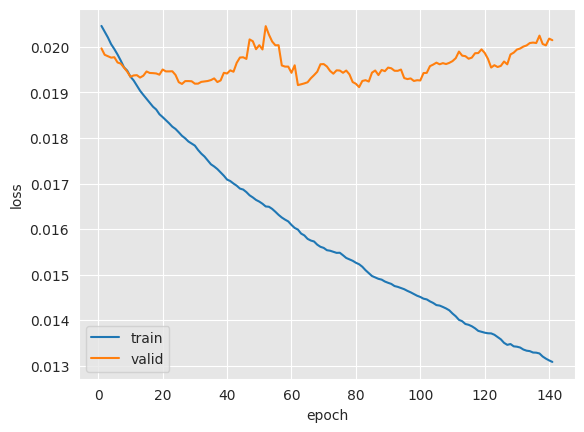

In [22]:
ma_window = 10

plt.plot(np.arange(len(epochs_train_losses)-ma_window + 1)+1, np.convolve(epochs_train_losses, np.ones(ma_window)/ma_window, mode='valid'))
plt.plot(np.arange(len(epochs_test_losses)-ma_window + 1)+1, np.convolve(epochs_test_losses, np.ones(ma_window)/ma_window, mode='valid'))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
#plt.ylim([0.01,0.06])

In [23]:
print(training_execution_time)

141.36414337158203


One can note here how the training loss decreases epoch after epoch. This means that the optimization is going well: the chosen learning rate allows to update the model towards a better solution (lower loss) for the **training dataset**. However, neural networks are known to be very expressive models. In fact, the universal approximation theorem shows that, with enough neurons/layers, one can model any function with a neural network {cite}`cybenko1989approximation`. Therefore, it is expected for a complex neural network to be able to fit almost perfectly the training data. But the ultimate goal is to obtain a model that generalizes well on unseen data (like the validation set). Looking at the validation loss, one can see that it starts by decreasing (with oscillations) and it reaches an optimum around 0.019, and stops decreasing (or even starts increasing). This phenomenon is referred to as [overfitting](Model_Selection).

Many aspects can be improved in the training. Although one cannot measure the performance on the final test set while training, one can rely on a validation set and try to stop training before overfitting (see [](Model_Selection)). One can also change the optimization algorithm and parameters to speed up training and reach a better optimum. This is investigated later, in the optimization paragraph.

For now, let us consider this final fitted model and evaluate it the same way as the other models in previous chapters. For this, let us create a prediction DataFrame and call the `performance_assessment` function from the shared functions. 

In [24]:
start_time=time.time() 
predictions_test = model(x_test.to(DEVICE))
prediction_execution_time = time.time()-start_time
predictions_train = model(x_train.to(DEVICE))
print("Predictions took", prediction_execution_time,"seconds.")

Predictions took 0.08955574035644531 seconds.


In [25]:
predictions_df=test_df
predictions_df['predictions']=predictions_test.detach().cpu().numpy()
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.859,0.636,0.276


This first shot feed-forward network already obtains a decent performance on the test set (refer to [Chapter 3.4](Baseline_FDS_Performances_Simulation) for comparison). But several elements can be modified to improve the AUC ROC, reduce the training time, etc.

As stated above, for the first model, optimization was not carried out properly because the validation performance is not exploited during the training process. To avoid overfitting in practice, it is necessary to take it into account (See Chapter 5, [](Hold_Out_Validation)).

In [26]:
delta_valid = delta_test

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

# By default, scales input data
(train_df, valid_df)=scaleData(train_df, valid_df, input_features)

Let us implement an early stopping strategy. The idea is to detect overfitting, i.e. when validation error starts increasing, and stop the training process. Sometimes, the validation error might increase at a given epoch, but then decrease again. For that reason, it is important to also consider a patience parameter, i.e. a number of iterations for which the training process waits in order to make sure that the error is definitely increasing. 

In [27]:
class EarlyStopping:
    
    def __init__(self, patience=2, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = np.Inf
    
    def continue_training(self,current_score):
        if self.best_score > current_score:
            self.best_score = current_score
            self.counter = 0
            if self.verbose:
                print("New best score:", current_score)
        else:
            self.counter+=1
            if self.verbose:
                print(self.counter, " iterations since best score.")
                
        return self.counter <= self.patience        

In [28]:
seed_everything(SEED)

model = SimpleFraudMLP(len(input_features), 1000).to(DEVICE)

def prepare_generators(train_df,valid_df,batch_size=64):
    x_train = torch.FloatTensor(train_df[input_features].values)
    x_valid = torch.FloatTensor(valid_df[input_features].values)
    y_train = torch.FloatTensor(train_df[output_feature].values)
    y_valid = torch.FloatTensor(valid_df[output_feature].values)
    train_loader_params = {'batch_size': batch_size,
              'shuffle': True,
              'num_workers': 0}
    valid_loader_params = {'batch_size': batch_size,
              'num_workers': 0}
    # Generators
    
    training_set = FraudDataset(x_train, y_train)
    valid_set = FraudDataset(x_valid, y_valid)
    
    training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
    valid_generator = torch.utils.data.DataLoader(valid_set, **valid_loader_params)
    
    return training_generator,valid_generator

training_generator,valid_generator = prepare_generators(train_df,valid_df,batch_size=64)

criterion = torch.nn.BCELoss().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0005)

The training loop can now be adapted to integrate early stopping:

In [29]:
def training_loop(model,training_generator,valid_generator,optimizer,criterion,max_epochs=100,apply_early_stopping=True,patience=2,verbose=False):
    #Setting the model in training mode
    model.train()

    if apply_early_stopping:
        early_stopping = EarlyStopping(verbose=verbose,patience=patience)
    
    all_train_losses = []
    all_valid_losses = []
    
    #Training loop
    start_time=time.time()
    for epoch in range(max_epochs):
        model.train()
        train_loss=[]
        for x_batch, y_batch in training_generator:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()   
            train_loss.append(loss.item())
        
        #showing last training loss after each epoch
        all_train_losses.append(np.mean(train_loss))
        if verbose:
            print('')
            print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))
        #evaluating the model on the test set after each epoch    
        valid_loss = evaluate_model(model,valid_generator,criterion)
        all_valid_losses.append(valid_loss)
        if verbose:
            print('valid loss: {}'.format(valid_loss))
        if apply_early_stopping:
            if not early_stopping.continue_training(valid_loss):
                if verbose:
                    print("Early stopping")
                break
        
    training_execution_time=time.time()-start_time
    return model,training_execution_time,all_train_losses,all_valid_losses

model,training_execution_time,train_losses,valid_losses = training_loop(model,training_generator,valid_generator,optimizer,criterion,max_epochs=500,verbose=True)


Epoch 0: train loss: 0.1909453293226702
valid loss: 0.09363199234253071
New best score: 0.09363199234253071

Epoch 1: train loss: 0.09756324257181662
valid loss: 0.0697594450450823
New best score: 0.0697594450450823

Epoch 2: train loss: 0.0771319315970001
valid loss: 0.057125550083042494
New best score: 0.057125550083042494

Epoch 3: train loss: 0.06579174269987964
valid loss: 0.05029815454341349
New best score: 0.05029815454341349

Epoch 4: train loss: 0.06037377742391586
valid loss: 0.04628613653485892
New best score: 0.04628613653485892

Epoch 5: train loss: 0.05693923270981581
valid loss: 0.04364783475328176
New best score: 0.04364783475328176

Epoch 6: train loss: 0.05446632004059837
valid loss: 0.041660719547074676
New best score: 0.041660719547074676

Epoch 7: train loss: 0.05247876254831001
valid loss: 0.04006742318796981
New best score: 0.04006742318796981

Epoch 8: train loss: 0.05084442440153279
valid loss: 0.038856804505234856
New best score: 0.038856804505234856

Epoch 9

After 251 epochs, the model stops learning because the validation performance has not improved for three iterations. Here the optimal model (from epoch 248) is not saved, but this could be implemented by simply adding `torch.save(model.state_dict(), checkpoint_path)` in the `EarlyStopping` class whenever a new best performance is reached. This allows reloading the saved best checkpoint at the end of the training. 

Now that a clean optimization process is defined, one can consider several solutions to speed up and improve convergence towards a decent extremum. The most natural way to do so is to play with the optimizer hyperparameters like the learning rate and the batch size. With a large learning rate, gradient descent is fast at the beginning, but then the optimizer struggles to find the minimum. Adaptive learning rate techniques like Adam/RMSProp take into account the steepness by normalizing the learning rate with respect to the gradient norm. Below are the formulas to update on a model parameter $w_t$ with Adam.

$w_{t+1} = w_t - \frac{\eta}{\sqrt{\hat{v_t}+\epsilon}}*\hat{m_t}$

Where:

$m_t = \beta_1 * m_{t-1} + (1-\beta_1)*\nabla w_t$

$v_t = \beta_2 * v_{t-1} + (1-\beta_2)*(\nabla w_t)^2$

$\hat{m_t}=\frac{m_t}{1-\beta_1^t}$

$\hat{v_t}=\frac{v_t}{1-\beta_2^t}$

The difference with SGD is that here the learning rate is normalized using the "gradient norm" ($\approx \hat{m_t}$). To be more precise, the approach does not use the "raw" gradient $\nabla w_t$ and gradient norm $\nabla w_t^2$ but a momentum instead (convex combination between previous values and the current value), respectively $m_t$ and $v_t$. It also applies a decay over the iterations.

Let us try Adam with an initial learning rate of `0.0005` to see the difference with regular SGD. 

In [30]:
seed_everything(SEED)
model = SimpleFraudMLP(len(input_features), 1000).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
model,training_execution_time,train_losses_adam,valid_losses_adam = training_loop(model,training_generator,valid_generator,optimizer,criterion,verbose=True)


Epoch 0: train loss: 0.04549537263997611
valid loss: 0.02297105001962535
New best score: 0.02297105001962535

Epoch 1: train loss: 0.02667415130573608
valid loss: 0.020753495965936716
New best score: 0.020753495965936716

Epoch 2: train loss: 0.024774995235255233
valid loss: 0.022122191949213138
1  iterations since best score.

Epoch 3: train loss: 0.023550403145133885
valid loss: 0.021128300786313545
2  iterations since best score.

Epoch 4: train loss: 0.022702776894697217
valid loss: 0.019787286952789362
New best score: 0.019787286952789362

Epoch 5: train loss: 0.022256808035475438
valid loss: 0.019103816810033484
New best score: 0.019103816810033484

Epoch 6: train loss: 0.02177840587015248
valid loss: 0.019241980908316424
1  iterations since best score.

Epoch 7: train loss: 0.021256008361627384
valid loss: 0.019380146311723266
2  iterations since best score.

Epoch 8: train loss: 0.020836042437255453
valid loss: 0.01843901535399421
New best score: 0.01843901535399421

Epoch 9: 

(0.01, 0.06)

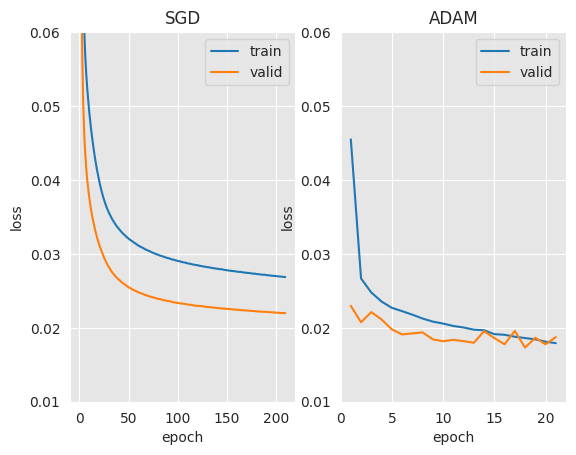

In [31]:
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_losses))+1, train_losses)
plt.plot(np.arange(len(valid_losses))+1, valid_losses)
plt.title("SGD")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim([0.01,0.06])

plt.subplot(1, 2, 2) 
plt.plot(np.arange(len(train_losses_adam))+1, train_losses_adam)
plt.plot(np.arange(len(valid_losses_adam))+1, valid_losses_adam)
plt.title("ADAM")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim([0.01,0.06])


The optimization is much faster with Adam (10 times fewer epochs) and it reaches a better optimum. Of course, increasing patience or changing the learning rate with SGD would probably help improve both speed and optimum. Nevertheless, Adam will be retained for the rest of the chapter as it usually allows very decent performance **without significant tuning**. To build the final neural network later, the tuning will mostly be made using batch size and initial learning rate. 

Here are only mentioned the optimizer's choice and some hyperparameters tuning for the optimization process. But keep in mind that neural network optimization is a very wide and active area of research/engineering. For instance, with Deep Networks, one can apply batch normalization after each layer to standardize the distribution and speed up convergence. One can also reduce the learning rate when validation loss reaches a plateau (`torch.optim.ReduceLROnPlateau`). For a full guide on Deep Learning optimization, we recommend {cite}`ruder2016overview,le2011optimization`.

## Regularization

A classical way to improve generalization and reach a better validation performance is to regularize the model. Roughly speaking, regularization consists in limiting the model expressiveness in order to reduce overfitting. 

The most common technique to regularize a machine learning model is to restrict its parameter space, for instance, its norm, by adding a term in the optimization problem. Additionally, to minimize the discrepancy between ground truth and prediction, integrating an L1 norm (resp. L2 norm) term in the loss will entail parameter sparsity (resp. will limit parameters amplitude). The initial solution space is generally full of equivalent solutions (e.g. with linear activations, dividing all input weights of a neuron by 2 and multiplying all of its output weights by 2 leads to an equivalent model), so the restrictions entailed by regularization not only limits overfitting but also reduces the search and can help with optimization. Finally, selecting a solution with minimal norm follows the principle of "All things being equal, the simplest solution tends to be the best one", a scientific principle often referred to as the [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor).

In contrast to adding loss terms, there is a regularization technique specifically designed for Neural Networks called dropout. Dropout consists in randomly dropping some neurons from the network at each training step. More precisely, one fixes a dropout parameter p∈[0,1], and, for each mini-batch, for each neuron, performs a coin toss (Bernoulli) with probability p. If positive, one temporarily sets the neuron's weights to zero (so that the dropped neuron is not considered during the forward and backward passes). It is equivalent to training a random sub-network at each mini-batch (Figure 5), and it can be proven that this has an L2-regularization effect on specific architectures {cite}`srivastava2014dropout`.

![alt text](./images/dropout.png)
Image source: {cite}`srivastava2014dropout`

To implement it, let us define a new model with an additional `torch.nn.Dropout` layer.

In [32]:
class SimpleFraudMLPWithDropout(torch.nn.Module):
    
        def __init__(self, input_size, hidden_size,p):
            super(SimpleFraudMLPWithDropout, self).__init__()
            # parameters
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.p = p
            
            #input to hidden
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
            self.dropout = torch.nn.Dropout(self.p)
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            hidden = self.dropout(hidden)
            
            output = self.fc2(hidden)
            output = self.sigmoid(output)
            
            return output

Note that setting the model in training/evaluation mode with the methods `model.eval()` and `model.train()` take all its significance here. In particular, the dropout layer in the forward pass is only applied when the model is in training mode.

In [33]:
seed_everything(SEED)
model = SimpleFraudMLPWithDropout(len(input_features), 1000,0.2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
model,training_execution_time,train_losses_dropout,valid_losses_dropout = training_loop(model,training_generator,valid_generator,optimizer,criterion,verbose=False)

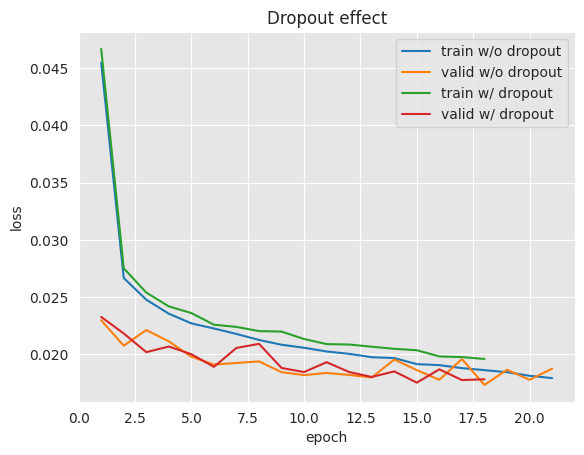

In [34]:
plt.plot(np.arange(len(train_losses_adam))+1, train_losses_adam)
plt.plot(np.arange(len(valid_losses_adam))+1, valid_losses_adam)
plt.plot(np.arange(len(train_losses_dropout))+1, train_losses_dropout)
plt.plot(np.arange(len(valid_losses_dropout))+1, valid_losses_dropout)
plt.title("Dropout effect")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train w/o dropout','valid w/o dropout','train w/ dropout','valid w/ dropout'])

It is generally reported that a small dropout value can lead to better generalization results than no dropout, but it can sometimes be the opposite if the training data are very rich, if the training distribution is close to the valid/test distribution, and if the model is already not too expressive. So, the best practice is to consider dropout as a hyperparameter (that could be set to 0) and tune it with a hyperparameter search. 

In addition to the L2-regularization effect, dropout can be seen as a very powerful mechanism that mimics ensembling strategies like bagging (the model can be seen as an ensemble of submodels trained on different subsets of data) {cite}`goodfellow2016deep`. 

## Scaling the inputs

XGBoost and random forests learn splits on single features and therefore are robust to the scale and distribution of the values. On the contrary, in a neural network, each neuron of the first layer learns a linear combination of all the features. Therefore, it is easier to train the neurons when all features have the same range and are normally distributed. The first property can be easily implemented by applying min-max or standard scaling on the features. As for the second property, it depends on the original distribution of the features. Some of them are not normally distributed and have non-linear scales (e.g. amount): increasing the amount by 5 dollars should not have the same effect if the starting point is 5 dollars or if the starting point is 100 dollars. It turns out that applying the log function on such features can make their distribution slightly more normal which makes it easier for feed-forward neural networks to learn from them. 

In [35]:
(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

For instance here is how the original amounts look like:

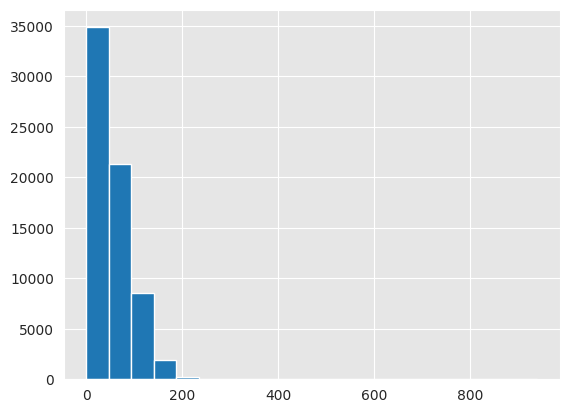

In [36]:
_ = plt.hist(train_df['TX_AMOUNT'].values,bins=20)

And now let us apply the log function to it. To obtain a positive log for the feature that is in [0,+∞[, an idea is to add 1 and then apply the log function (which is equivalent to applying the `log1p` function in `numpy`). This leads to a preprocessed feature that belongs to [0,+∞[ and it can then be standardized. Here is how the amounts are distributed after all these steps:

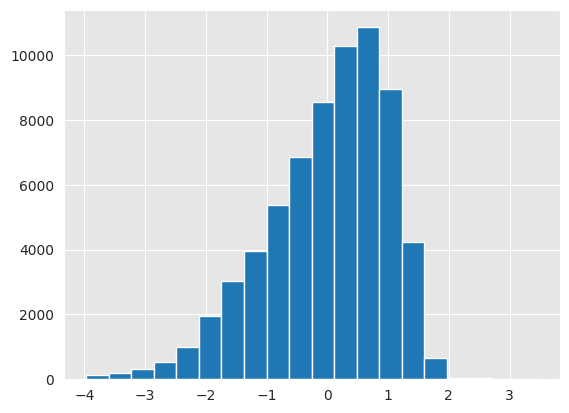

In [37]:
_ = plt.hist(sklearn.preprocessing.StandardScaler().fit_transform(np.log1p(train_df['TX_AMOUNT'].values).reshape(-1, 1)),bins=20)

Note that here, our artificial data were generated with Gaussians so the `np.log1p` is not very useful in practice. But keep in mind that on real-world data, the original scale of features like amount is far from normally distributed and this operation turns out to be quite often useful. 

Let us forget about the log for now and just analyze the impact of scaling the features on our Neural Network's training. More precisely, let us see the difference between no scaling at all and standard scaling. A smaller learning rate of `0.0001` will be chosen here for the experiment without scaling to avoid divergence.

In [38]:
#we did not call the function scaleData this time
seed_everything(SEED)
training_generator,valid_generator = prepare_generators(train_df,valid_df,batch_size=64)

model = SimpleFraudMLPWithDropout(len(input_features), 1000,0.2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model,training_execution_time,train_losses_without_scaling,valid_losses_without_scaling = training_loop(model,training_generator,valid_generator,optimizer,criterion,verbose=False)

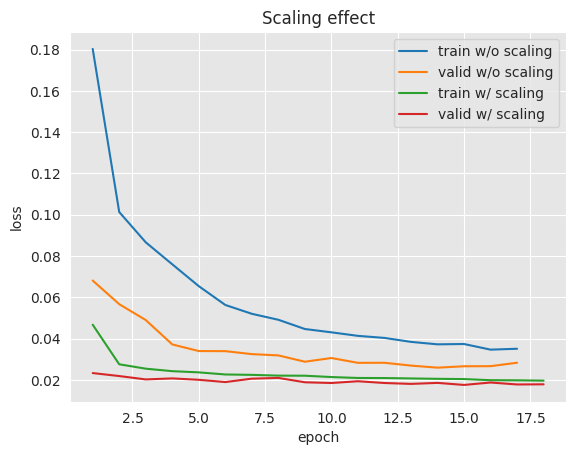

In [39]:
plt.plot(np.arange(len(train_losses_without_scaling))+1, train_losses_without_scaling)
plt.plot(np.arange(len(valid_losses_without_scaling))+1, valid_losses_without_scaling)
plt.plot(np.arange(len(train_losses_dropout))+1, train_losses_dropout)
plt.plot(np.arange(len(valid_losses_dropout))+1, valid_losses_dropout)
plt.title('Scaling effect')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train w/o scaling','valid w/o scaling','train w/ scaling','valid w/ scaling'])

The train/valid losses are smoother and reach much better levels faster when the data is normalized with standard scaling.

In [40]:
# Let us rescale data for the next parts
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)

## Embeddings

Properly taking into account categorical variables is maybe one of the main advantages of neural networks. In the first chapters, [feature transformation techniques](Baseline_Feature_Transformation) were applied to categorical features like day, Customer ID, Terminal ID, in order to make them binary or to extract numerical features from them. 

In real-world data, categorical features are frequent (Country, Merchant Type, hour, type of payment, ...). But most machine learning algorithms require features to be numerical. Take the example of linear regression: it is basically a weighted sum of the features' values. For numerical features, it makes sense to consider that their impact is proportional to their value (e.g. the smaller the delay between two transactions, the higher the fraud risk), but it does not make sense for a nominal feature like a Country that can take the values "USA", "France", "Belgium". For the latter, a transformation is necessary. The most common choices are:

* One-hot encoding: a binary feature is defined for each modality (e.g. "country_is_USA", "country_is_France" and "country_is_Belgium").
* Frequency-based encoding: The frequency (or another statistic) of each modality is computed and the index of the modality is replaced with the value of the statistic. 
* Label-correlation encoding: It is close to frequency encoding but here a statistic correlated with the label is computed. For instance, each modality can be replaced with its proportion of fraud in the training data. 

With neural networks, one can make use of embedding layers to encode categorical variables. More precisely, the idea is to let the neural network itself learn a representation of each modality of the categorical variable in a continuous vector space of dimension k, chosen by the practitioner. These representations can be learned end-to-end to make the feed-forward network optimal for the fraud detection task. They can also be learned with a different objective like predicting the sequences of countries visited by cardholders (unsupervised pre-training) and then later used for fraud detection, either with a neural network classifier or any other classifier (XGBoost, random forest, etc.). 

![Embedding layer illustration](./images/embedding.png)

Note that learning an embedding of dimension $k$ for a categorical feature is computationally equivalent to learning a classical fully connected layer that takes as input the one-hot encoding of the feature and outputs $k$ neurons.

To test embedding layers, let us try to add extra categorical inputs in $x$ and let the model learn embedding for them. Our last neural network was trained on the following features:

In [41]:
input_features

['TX_AMOUNT',
 'TX_DURING_WEEKEND',
 'TX_DURING_NIGHT',
 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
 'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW',
 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
 'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW',
 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
 'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW',
 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
 'TERMINAL_ID_RISK_1DAY_WINDOW',
 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
 'TERMINAL_ID_RISK_7DAY_WINDOW',
 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
 'TERMINAL_ID_RISK_30DAY_WINDOW']

Let us add, for example, the raw terminal id and the day of the week as categorical input features:

In [42]:
def weekday(tx_datetime):
    
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    
    return int(weekday)

In [43]:
train_df['TX_WEEKDAY'] = train_df.TX_DATETIME.apply(weekday)
valid_df['TX_WEEKDAY'] = valid_df.TX_DATETIME.apply(weekday)
input_categorical_features = ['TX_WEEKDAY','TERMINAL_ID']


Let us now define a new neural network model with two embedding layers. `TX_WEEKDAY` and `TERMINAL_ID` will both go through one of them, and each will be turned into a vector. Then they will be concatenated with the numerical features and the whole will go through a network similar to our previous architecture.

In [44]:
class FraudMLPWithEmbedding(torch.nn.Module):
    
        def __init__(self, categorical_inputs_modalities,numerical_inputs_size,embedding_sizes, hidden_size,p):
            super(FraudMLPWithEmbedding, self).__init__()
            # parameters
            self.categorical_inputs_modalities = categorical_inputs_modalities
            self.numerical_inputs_size = numerical_inputs_size
            self.embedding_sizes = embedding_sizes
            self.hidden_size  = hidden_size
            self.p = p
            
            assert len(categorical_inputs_modalities)==len(embedding_sizes), 'categorical_inputs_modalities and embedding_sizes must have the same length'
            
            #embedding layers
            self.emb = []
            for i in range(len(categorical_inputs_modalities)):
                self.emb.append(torch.nn.Embedding(int(categorical_inputs_modalities[i]), int(embedding_sizes[i])).to(DEVICE))
                
            
            #contenated inputs to hidden
            self.fc1 = torch.nn.Linear(self.numerical_inputs_size+int(np.sum(embedding_sizes)), self.hidden_size)
            self.relu = torch.nn.ReLU()
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
            self.dropout = torch.nn.Dropout(self.p)
            
        def forward(self, x):
            #we assume that x start with numerical features then categorical features
            inputs = [x[:,:self.numerical_inputs_size]]
            for i in range(len(self.categorical_inputs_modalities)):
                inputs.append(self.emb[i](x[:,self.numerical_inputs_size+i].to(torch.int64)))
            
            x = torch.cat(inputs,axis=1)
            
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            hidden = self.dropout(hidden)
            
            output = self.fc2(hidden)
            output = self.sigmoid(output)
            
            return output

In [45]:
def prepare_generators_with_categorical_features(train_df,valid_df,input_categorical_features,batch_size=64):
    x_train = torch.FloatTensor(train_df[input_features].values)
    x_valid = torch.FloatTensor(valid_df[input_features].values)
    y_train = torch.FloatTensor(train_df[output_feature].values)
    y_valid = torch.FloatTensor(valid_df[output_feature].values)
    
    #categorical variables : encoding valid according to train
    encoder = sklearn.preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
    x_train_cat = encoder.fit_transform(train_df[input_categorical_features].values) + 1
    categorical_inputs_modalities = np.max(x_train_cat,axis=0)+1
    
    x_train_cat = torch.IntTensor(x_train_cat)
    x_valid_cat = torch.IntTensor(encoder.transform(valid_df[input_categorical_features].values) + 1)
    
    x_train = torch.cat([x_train,x_train_cat],axis=1)
    x_valid = torch.cat([x_valid,x_valid_cat],axis=1)
    
    train_loader_params = {'batch_size': batch_size,
              'shuffle': True,
              'num_workers': 0}
    valid_loader_params = {'batch_size': batch_size,
              'num_workers': 0}
    
    # Generators
    training_set = FraudDataset(x_train, y_train)
    valid_set = FraudDataset(x_valid, y_valid)
    
    training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
    valid_generator = torch.utils.data.DataLoader(valid_set, **valid_loader_params)
    
    return training_generator,valid_generator, categorical_inputs_modalities

Now let us train this new model with an embedding dimension of 10 for each categorical feature. 

In [46]:
seed_everything(SEED)
training_generator,valid_generator,categorical_inputs_modalities = prepare_generators_with_categorical_features(train_df,valid_df,input_categorical_features,batch_size=64)

embedding_sizes = [10]*len(categorical_inputs_modalities)

model = FraudMLPWithEmbedding(categorical_inputs_modalities,len(input_features),embedding_sizes, 1000,0.2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model,training_execution_time,train_losses_embedding,valid_losses_embedding = training_loop(model,training_generator,valid_generator,optimizer,criterion,verbose=False)

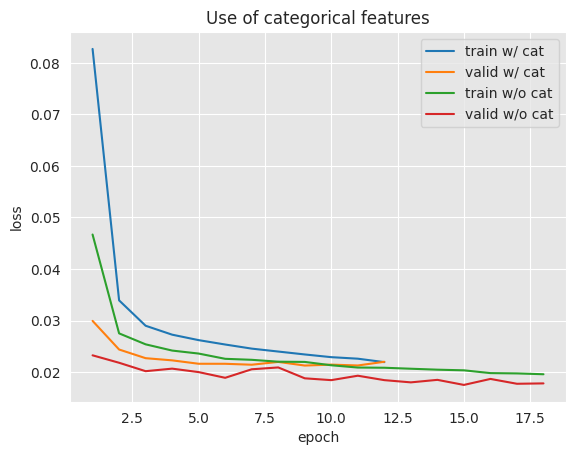

In [47]:
plt.plot(np.arange(len(train_losses_embedding))+1, train_losses_embedding)
plt.plot(np.arange(len(valid_losses_embedding))+1, valid_losses_embedding)
plt.plot(np.arange(len(train_losses_dropout))+1, train_losses_dropout)
plt.plot(np.arange(len(valid_losses_dropout))+1, valid_losses_dropout)
plt.title('Use of categorical features')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train w/ cat','valid w/ cat','train w/o cat','valid w/o cat'])

The performance here is not necessarily better with the categorical features (they do not add value compared to the engineered features, at least for the fraud patterns in our categorical data). This implementation is shown for educational purposes. Keep in mind that embedding layers are often a valuable solution in practice when training with a lot of data because it is a step forward in automation (instead of expert feature engineering, one can leave the representation choice to the model). 

Embedding can also be interesting for interpretability. Indeed, at the end of training, one can extract `model.emb[i].weight`. Each row of this matrix represents the embedding vector of a given modality for the `i-th` categorical feature. This can be used to compute similarities between modalities. One can also reduce these vectors' dimensionality with TSNE or PCA and visualize all modalities on a 2D plane.

## Ensemble

To go further and improve the results, ensembling is a common strategy with neural networks in general and for fraud detection. 

The idea is to simply train the architecture several times and average the predictions of all the obtained models at inference {cite}`zhou2021ensemble`. Layer initialization and the random batch order are generally enough to ensure diversity between each submodel and make the ensemble better than each individual. To go further, one can also train each individual on a different train/valid split {cite}`breiman1996bagging`.

Ensembling is also very useful for fraud detection, in particular, because of concept drift. Indeed, in fraud detection, the fraudsters' techniques are varied and change over time. A single model can struggle to both learn and remember all the different patterns for the target class. In this context, it is expected that an ensemble of models, efficiently built, can cope with the issue. The intuition is that the different components of the ensemble can be specialized for different tasks. For example, a component could be specialized for the recent patterns and another for the old patterns {cite}`lebichot2021incremental`. Similarly, a component could be specialized for the easiest and generic fraudsters’ strategies and another for advanced concepts.

(Model_Selection_FFNN)=
## Prequential grid search

The above sections have shown many design choices for the neural network. Let us now follow the prequential methodology from Chapter 5 and perform a grid search to see the impact of some hyperparameters on the performance and be able to compare the results with other baselines from previous chapters.

Let us consider the following ranges:
* Batch size : [64,128,256]
* Initial learning rate: [0.0001, 0.0002, 0.001]
* Dropout rate : [0, 0.2, 0.4]
* Hidden layer dimension : [500]
* Number of hidden layers : [1,2]

To use the same procedure as in previous chapters (with GridSearchCV), we have to make the neural network compatible with `sklearn` functions. We will resort to the library `skorch`, which provides an `sklearn` wrapper for `PyTorch` modules. Also, early stopping won't be used, but instead the number of epochs ([10,20,40]) will be another parameter to search.

In [48]:
!pip install skorch

Defaulting to user installation because normal site-packages is not writeable


In [49]:
from skorch import NeuralNetClassifier

In order to make this work, several aspects of our previous Python classes have to be adapted. First, `sklearn`'s classifiers have two output probabilities (one for each class) that are complementary. Therefore, the output of `fc2` has to be changed to 2, and the activation to `softmax` (similar to the sigmoid activation but with a global normalization). Second, the dataset has to expect arrays instead of tensors, so the conversion will be done within the dataset. 

In [50]:
class FraudMLP(torch.nn.Module):
    
        def __init__(self, hidden_size=100,num_layers=1,p=0, input_size=len(input_features)):
            super(FraudMLP, self).__init__()
            # parameters
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.p = p
            
            #input to hidden
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            
            self.fc_hidden=[]
            for i in range(num_layers-1):
                self.fc_hidden.append(torch.nn.Linear(self.hidden_size, self.hidden_size))
                self.fc_hidden.append(torch.nn.ReLU())
                
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 2)
            self.softmax = torch.nn.Softmax()
            
            self.dropout = torch.nn.Dropout(self.p)
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)             
            hidden = self.dropout(hidden)
            
            for layer in self.fc_hidden:
                hidden=layer(hidden)
                hidden = self.dropout(hidden)
            
            output = self.fc2(hidden)
            output = self.softmax(output)
            
            return output

In [51]:
class FraudDatasetForPipe(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        'Initialization'
        self.x = torch.FloatTensor(x)
        self.y = None
        if y is not None:
            self.y = torch.LongTensor(y.values)
        

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        if self.y is not None:
            return self.x[index], self.y[index]
        else:
            return self.x[index], -1       

Now that the module and Dataset are adapted, one can obtain an "sklearn-like" model using the `NeuralNetClassifier` wrapper from `skorch`. Note that we can set the device directly as a parameter in that class.

In [52]:
net = NeuralNetClassifier(
    FraudMLP,
    max_epochs=2,
    lr=0.001,
    optimizer=torch.optim.Adam,
    batch_size=64,
    dataset=FraudDatasetForPipe,
    iterator_train__shuffle=True
)
net.set_params(train_split=False, verbose=0)

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.FraudMLP'>,
)

To test it, let us perform a first small grid search by playing on the number of epochs and number of layers.

In [53]:
# Testing the wrapper

#X=train_df[input_features].values
#y=train_df[output_feature]
#
#net.fit(X, y)
#net.predict_proba(X)

In [54]:
# Only keep columns that are needed as argument to custom scoring function
# to reduce serialization time of transaction dataset
transactions_df_scorer=transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

# Make scorer using card_precision_top_k_custom
card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

n_folds=4
start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)
delta_assessment = delta_valid

In [55]:
seed_everything(SEED)
start_time=time.time()

parameters = {
    'clf__lr': [0.001 ],
    'clf__batch_size': [64],
    'clf__max_epochs': [10, 20],
    'clf__module__hidden_size': [100],
    'clf__module__num_layers': [1,2],
    'clf__module__p': [0],
}

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }


performance_metrics_list_grid=['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100']

performances_df_validation=prequential_grid_search(
    transactions_df, net, 
    input_features, output_feature,
    parameters, scoring, 
    start_date_training=start_date_training_with_valid,
    n_folds=n_folds,
    expe_type='Validation',
    delta_train=delta_train, 
    delta_delay=delta_delay, 
    delta_assessment=delta_valid,
    performance_metrics_list_grid=performance_metrics_list_grid,
    performance_metrics_list=performance_metrics_list)

print("Validation: Total execution time: "+str(round(time.time()-start_time,2))+"s")

/tmp/ipykernel_228704/3810348946.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/tmp/ipykernel_228704/3810348946.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/tmp/ipykernel_228704/3810348946.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/tmp/ipykernel_228704/3810348946.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/tmp/ipykernel_228704/3810348946.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/tmp/ipykernel_228704/3810348946.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/tmp/ipykernel_228704/3810348946.p

Validation: Total execution time: 32.8s


/home/latif/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/latif/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
  File "/home/latif/.local/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
TypeError: card_precision_top_k_custom() got an unexpected keyword argument 'needs_proba'

  warnings.warn(


In [57]:
performances_df_validation

,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters,Execution time
0,0.874126,0.011732,0.659973,0.013950,NaN,NaN,"{'clf__batch_size': 64, 'clf__lr': 0.001, 'clf...",16.669888
1,0.878145,0.010790,0.660632,0.013952,NaN,NaN,"{'clf__batch_size': 64, 'clf__lr': 0.001, 'clf...",18.800813
2,0.875172,0.009507,0.675190,0.016502,NaN,NaN,"{'clf__batch_size': 64, 'clf__lr': 0.001, 'clf...",25.192623
3,0.879574,0.009012,0.684901,0.010039,NaN,NaN,"{'clf__batch_size': 64, 'clf__lr': 0.001, 'clf...",28.462967


Validation seems to be running smoothly and the results already look promising. 

Let us now perform a proper model selection using the protocol from Chapter 5.3, [](Model_Selection).

In [ ]:
seed_everything(SEED)


parameters = {
    'clf__lr': [0.001 , 0.0001, 0.0002],
    'clf__batch_size': [64,128,256],
    'clf__max_epochs': [10,20,40],
    'clf__module__hidden_size': [500],
    'clf__module__num_layers': [1,2],
    'clf__module__p': [0,0.2,0.4],
    'clf__module__input_size': [int(len(input_features))],
}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, net, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=10)


execution_time_nn = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__lr'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__batch_size'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_epochs'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__module__p'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__module__num_layers'])
                                   for i in range(len(parameters_dict))]

performances_df_nn=performances_df

import pickle

with open("sequential_modeling.pkl", "wb") as f:
    pickle.dump(classifier, f)


/tmp/ipykernel_228704/3810348946.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/tmp/ipykernel_228704/3810348946.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/tmp/ipykernel_228704/3810348946.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/tmp/ipykernel_228704/3810348946.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/tmp/ipykernel_228704/3810348946.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/tmp/ipykernel_228704/3810348946.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/tmp/ipykernel_228704/3810348946.p

KeyboardInterrupt: 

In [59]:
import pickle

with open("sequential_modeling.pkl", "wb") as f:
    pickle.dump(classifier, f)

performances_df_nn

NameError: name 'classifier' is not defined

In [ ]:
execution_time_nn

7350.9550194740295

Since the number of parameters to tune is large here, and the training (with 20-40 epochs) is rather slow, the execution of the grid-search can take a long time (7350 seconds here). Indeed, it requires training 162 neural networks for each train/valid split of the prequential validation. To speed up the process, it would be beneficial to adopt the random search as suggested at the end of Section 5.3 or to use a hyperparameter tuning method more adapted to neural networks.

In [ ]:
summary_performances_nn=get_summary_performances(performances_df_nn, parameter_column_name="Parameters summary")
summary_performances_nn

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,0.001/256/40/0.4/1,0.001/64/40/0.4/1,0.0002/64/40/0.2/2
Validation performance,0.881+/-0.01,0.701+/-0.01,0.288+/-0.01
Test performance,0.876+/-0.01,0.675+/-0.01,0.303+/-0.02
Optimal parameter(s),0.0002/64/40/0.2/2,0.001/128/40/0.4/1,0.001/256/20/0.4/2
Optimal test performance,0.878+/-0.01,0.683+/-0.01,0.304+/-0.02


The optimal sets of hyperparameters strongly depend on the metric. The majority slightly favors the largest learning rate `0.001` and 2 hidden layers. Let us consider these values and visualize the impact of the others (batch size, number of epochs, and dropout).

In [ ]:
parameters_dict=dict(performances_df_nn['Parameters'])
performances_df_nn['Parameters summary']=[
                                   str(parameters_dict[i]['clf__batch_size'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_epochs'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__module__p'])
    
                                   for i in range(len(parameters_dict))]

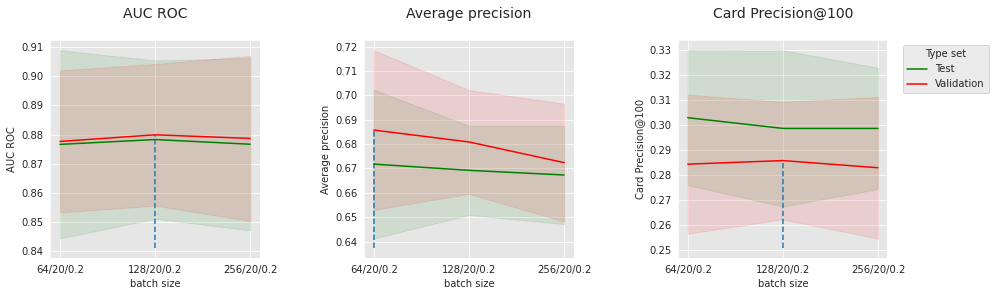

In [ ]:
performances_df_nn_subset = performances_df_nn[performances_df_nn['Parameters'].apply(lambda x:x['clf__lr']== 0.001 and x['clf__module__hidden_size']==500 and x['clf__module__num_layers']==2 and x['clf__module__p']==0.2 and x['clf__max_epochs']==20).values]
summary_performances_nn_subset=get_summary_performances(performances_df_nn_subset, parameter_column_name="Parameters summary")
indexes_summary = summary_performances_nn_subset.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_performances_nn_subset.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(performances_df_nn_subset, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="batch size",
                       summary_performances=summary_performances_nn_subset)

First, if we fix the number of epochs to 20, the dropout level to 0.2, the lower batch size leads to better results for average precision and card precision on the test set, whereas there is a sweet spot according to AUC-ROC. In fact, the optimal batch size is strongly connected to other optimizer parameters. Often, a larger batch size requires a larger number of epochs. To verify that, let us visualize the same plots but with the number of epochs to 40.

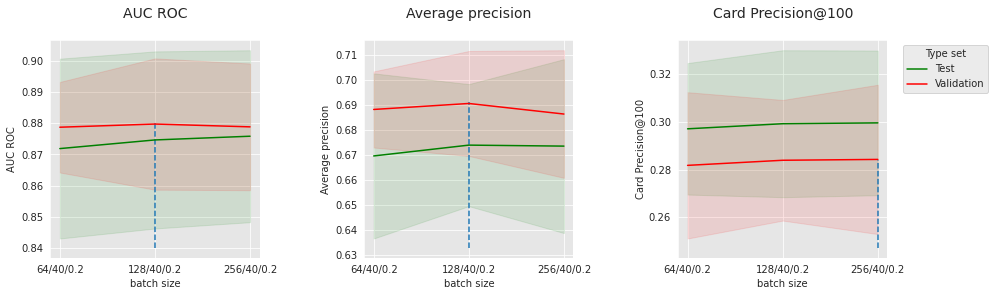

In [ ]:
performances_df_nn_subset = performances_df_nn[performances_df_nn['Parameters'].apply(lambda x:x['clf__lr']== 0.001 and x['clf__module__hidden_size']==500 and x['clf__module__num_layers']==2 and x['clf__module__p']==0.2 and x['clf__max_epochs']==40).values]
summary_performances_nn_subset=get_summary_performances(performances_df_nn_subset, parameter_column_name="Parameters summary")
indexes_summary = summary_performances_nn_subset.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_performances_nn_subset.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(performances_df_nn_subset, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="batch size",
                       summary_performances=summary_performances_nn_subset)

With this higher number of epochs, the optimal batch size is now globally higher. Let us now do the contrary, i.e. fix the batch size to some value (e.g. 64) and visualize the impact of the number of epochs.

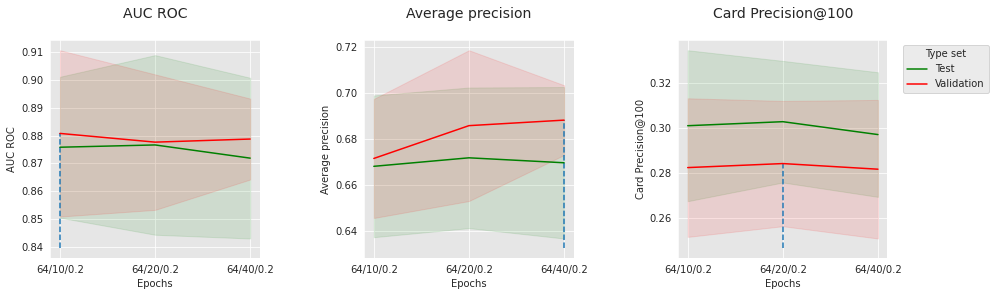

In [ ]:
performances_df_nn_subset = performances_df_nn[performances_df_nn['Parameters'].apply(lambda x:x['clf__lr']== 0.001 and x['clf__module__hidden_size']==500 and x['clf__module__num_layers']==2 and x['clf__module__p']==0.2 and x['clf__batch_size']==64).values]
summary_performances_nn_subset=get_summary_performances(performances_df_nn_subset, parameter_column_name="Parameters summary")
indexes_summary = summary_performances_nn_subset.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_performances_nn_subset.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(performances_df_nn_subset, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Epochs",
                       summary_performances=summary_performances_nn_subset)

The optimal number of epochs also depends on the metric and has a sweet spot strongly connected to the choice of other hyperparameters.

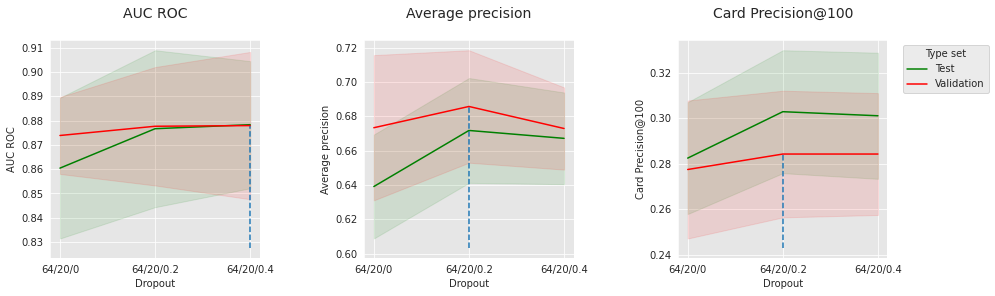

In [ ]:
performances_df_nn_subset = performances_df_nn[performances_df_nn['Parameters'].apply(lambda x:x['clf__lr']== 0.001 and x['clf__module__hidden_size']==500 and x['clf__module__num_layers']==2 and x['clf__max_epochs']==20 and x['clf__batch_size']==64).values]
summary_performances_nn_subset=get_summary_performances(performances_df_nn_subset, parameter_column_name="Parameters summary")
indexes_summary = summary_performances_nn_subset.index.values
indexes_summary[0] = 'Best estimated parameters'
summary_performances_nn_subset.rename(index = dict(zip(np.arange(len(indexes_summary)),indexes_summary)))
get_performances_plots(performances_df_nn_subset, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Dropout",
                       summary_performances=summary_performances_nn_subset)

parameters_dict=dict(performances_df_nn['Parameters'])
performances_df_nn['Parameters summary']=[str(parameters_dict[i]['clf__lr'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__batch_size'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_epochs'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__module__p'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__module__num_layers'])
                                   for i in range(len(parameters_dict))]

As for the dropout, it helps generalize and improve the valid/test metrics. However, when the dropout value is too high (0.4), it can deteriorate the results, e.g. by limiting the fitting power or by requiring a larger number of epochs.

## Saving of results 

Let us save the performance results and execution times of the neural network models in a Python pickle format. 

In [ ]:
performances_df_dictionary={
    "Neural Network": performances_df_nn
}

execution_times=[execution_time_nn]

filehandler = open('performances_model_selection_nn.pkl', 'wb') 
pickle.dump((performances_df_dictionary, execution_times), filehandler)
filehandler.close()

## Benchmark summary

Let us finally retrieve the performance results obtained in [Chapter 5](Model_Selection_Comparison_Performances) with decision tree, logistic regression, random forest and XGBoost, and compare them with those obtained with a feed-forward neural network. The results can be retrieved by loading the `performances_model_selection.pkl` and `performances_model_selection_nn.pkl` pickle files, and summarized with the `get_summary_performances` function.

In [7]:
# Load performance results for decision tree, logistic regression, random forest and XGBoost
filehandler = open('../Chapter_5_ModelValidationAndSelection/performances_model_selection.pkl', 'rb') 
(performances_df_dictionary, execution_times) = pickle.load(filehandler)

# Load performance results for feed-forward neural network
filehandler = open('performances_model_selection_nn.pkl', 'rb') 
(performances_df_dictionary_nn, execution_times_nn) = pickle.load(filehandler)


In [15]:
performances_df_dt=performances_df_dictionary['Decision Tree']
summary_performances_dt=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")

performances_df_lr=performances_df_dictionary['Logistic Regression']
summary_performances_lr=get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")

performances_df_rf=performances_df_dictionary['Random Forest']
summary_performances_rf=get_summary_performances(performances_df_rf, parameter_column_name="Parameters summary")

performances_df_xgboost=performances_df_dictionary['XGBoost']
summary_performances_xgboost=get_summary_performances(performances_df_xgboost, parameter_column_name="Parameters summary")

performances_df_nn=performances_df_dictionary_nn['Neural Network']
summary_performances_nn=get_summary_performances(performances_df_nn, parameter_column_name="Parameters summary")

summary_test_performances = pd.concat([summary_performances_dt.iloc[2,:],
                                       summary_performances_lr.iloc[2,:],
                                       summary_performances_rf.iloc[2,:],
                                       summary_performances_xgboost.iloc[2,:],
                                       summary_performances_nn.iloc[2,:],
                                      ],axis=1)

summary_test_performances.columns=['Decision Tree', 'Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network']


The results are summarized in a `summary_test_performances` table. Rows provide the average performance results on the test sets in terms of AUC ROC, Average Precision and CP@100. 

In [16]:
summary_test_performances

,Decision Tree,Logistic Regression,Random Forest,XGBoost,Neural Network
AUC ROC,0.797+/-0.01,0.868+/-0.02,0.87+/-0.02,0.869+/-0.01,0.876+/-0.01
Average precision,0.579+/-0.01,0.623+/-0.02,0.678+/-0.01,0.687+/-0.01,0.675+/-0.01
Card Precision@100,0.284+/-0.0,0.297+/-0.01,0.299+/-0.01,0.303+/-0.01,0.303+/-0.02


Overall, it appears that our simple feed-forward neural network is a good competitor in terms of predictive performance for the fraud detection problem, providing the best performances in terms of AUC ROC and CP@100, and competitive performances in terms of Average Precision. Moreover, it benefits from many advantages (e.g. its ability for incremental learning), as mentioned in the previous section.

## Conclusion

This section gave an overview of how to design a feed-forward neural network for fraud detection. Comparatively to classical machine learning models, neural networks have an infinite set of hyperparameters. This modularity in the design has a lot of advantages in terms of expressivity but it comes at the cost of a time-consuming hyper optimization of the architecture, the activations, the loss, the optimizers, the preprocessing, etc. Nevertheless, there are many ways to automate hyper optimization and architecture design, for instance with AutoML including Neural Architecture Search (or NAS) {cite}`elsken2019neural`.

Here only the top of the iceberg is covered. There are many other aspects to consider even with such a simple neural network. Many of them can be found in good practice guides and generally also apply to fraud detection. Some are even specific to problems like the latter. An important one is to manage imbalance (refer to Chapter 6 for more details): it can be done with neural networks by replacing binary cross-entropy with a weighted BCE (putting more importance on the loss terms associated with fraud samples) or with focal loss, a variant of cross-entropy specifically designed to automatically focus on under-represented samples. Another way is to implement a custom Dataloader with a [balanced sampler](https://github.com/ufoym/imbalanced-dataset-sampler).

The rest of the chapter rather focuses on different types of neural network models like autoencoders or sequential models and the way they can be used in a fraud detection context.